In [4]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

In [351]:
class IsotropicUniaxial(object):
    def __init__(self, E, C):
        self.E = E
        self.C = C
        self.current_yield_stress = C(0)
        self.odk_history = []
        self.yield_stresses_history = []
        self.odkvist = 0
        self.strain_plast_cum = 0
        self.eps_elast = []
        self.eps_plast = []
        
        self.expected = []
        
        self.forecast_factor = 1.05 # 1.1 here is constant that try to approx how C will increase this step
        
    def __step__(self, prev_strain, prev_plastic_strain, strain, expected_prev):
        loading = (strain - prev_strain >= 0)
        
        if True:
            expected_stress = (strain - self.strain_plast_cum)*self.E
            self.expected.append(expected_stress)
            if np.abs(expected_stress) > self.current_yield_stress:
                
                if loading:
                    elastic_strain = self.current_yield_stress*self.forecast_factor/self.E#*np.sign(expected_stress) 
                    plastic_strain = strain - elastic_strain
                else:
                    elastic_strain = np.sign(expected_stress)*self.current_yield_stress*self.forecast_factor/self.E#*np.sign(expected_stress)
                    plastic_strain = strain - elastic_strain                    
                    
                    
                self.eps_elast.append(elastic_strain)
                self.eps_plast.append(plastic_strain)
                d_plastic_strain = plastic_strain - prev_plastic_strain
                self.odkvist += np.abs(d_plastic_strain)
                self.strain_plast_cum += d_plastic_strain
                self.current_yield_stress = self.C(np.sqrt(2/3)*self.odkvist)
                stress = self.current_yield_stress*np.sign(expected_stress)
            else:
                stress = (strain - self.strain_plast_cum)*self.E#expected_stress# strain*self.E
                plastic_strain = 0
                self.eps_elast.append(strain)
                self.eps_plast.append(0)
                
            self.odk_history.append(self.odkvist)
            self.yield_stresses_history.append(self.current_yield_stress)
        
#         else:
#             if np.abs(expected_stress) > self.current_yield_stress:
                
#             else:
#                 stress = strain*self.E
#                 plastic_strain = 0                
        return stress, strain, plastic_strain, expected_stress
    
            
    def predict(self, strain_seq):
        prev_strain = 0
        prev_plastic_strain = 0
        prev_expected = 0
        preds = []
        for i, strain in enumerate(strain_seq):
            pred, prev_strain, prev_plastic_strain, prev_expected = self.__step__(prev_strain, prev_plastic_strain, strain, prev_expected)
            preds.append(pred)
        return preds
    
    def fit(self, X, y):
        pass
            
        

In [352]:
def generate_deformation_trajectory(num_steps, start_deformation, max_deformation):
    """
    Generate deformation trajectory for uniaxial loading process with equal time steps.
    """
    deformation = np.linspace(start_deformation, max_deformation, num_steps)
    return deformation



In [353]:
n_point=500
loading = generate_deformation_trajectory(n_point, 0.0, 0.01)
unloading = generate_deformation_trajectory(2*n_point, 0.01, -0.01)
loading2 = generate_deformation_trajectory(2*n_point, -0.01, 0.01)

loading = np.concatenate([loading, unloading], axis=0)

In [354]:
C_table_x, C_table_y = [0, 16e-5, 61e-5, 11e-4, 21e-4, 48e-4, 71e-4, 1e-2, 1e-1], np.array([62, 144, 204, 228, 256, 295, 335, 350, 800])+245
C = lambda x: np.interp(x, C_table_x, C_table_y)
E=2e5

iso = IsotropicUniaxial(E, C)

In [355]:
245/E

0.001225

In [356]:
stresses = iso.predict(loading)

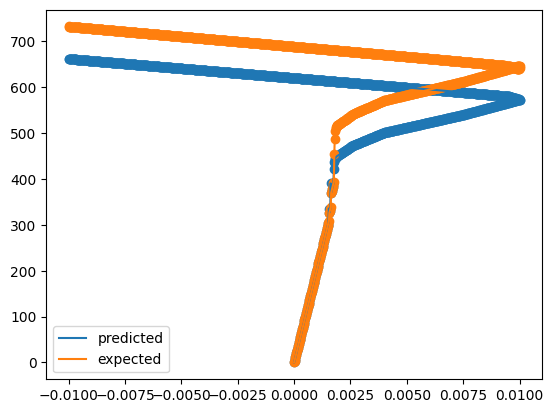

In [357]:
plt.plot(loading, stresses, label='predicted')
plt.scatter(loading, stresses)

plt.plot(loading, iso.expected, label='expected')
plt.scatter(loading, iso.expected)

plt.legend()

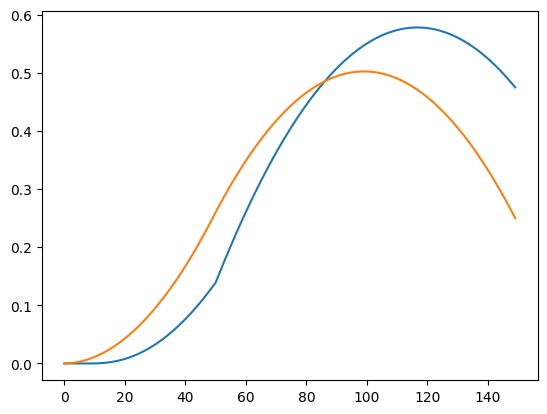

In [289]:
plt.plot(np.cumsum(iso.eps_plast))
plt.plot(np.cumsum(loading))

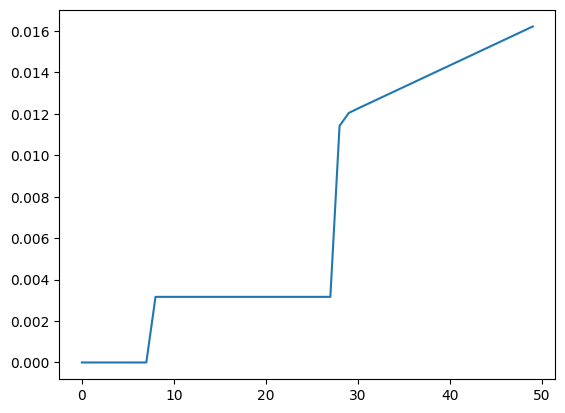

In [107]:
plt.plot(iso.odk_history)

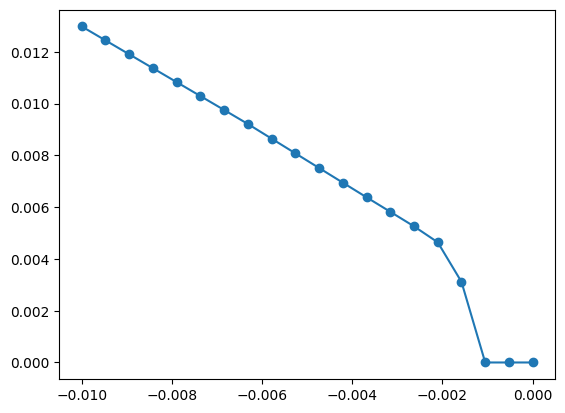

In [76]:
plt.plot(loading, iso.odk_history)
plt.scatter(loading, iso.odk_history)

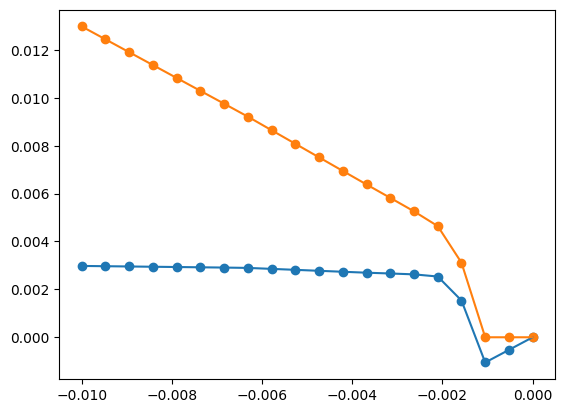

In [77]:
plt.plot(loading, iso.eps_elast)
plt.scatter(loading, iso.eps_elast)

plt.plot(loading, iso.eps_plast)
plt.scatter(loading, iso.eps_plast)

In [ ]:
import tqdm
from tqdm.auto import tqdm as tqdm
class IsotropicUniaxial(object):
    def __init__(self, E, nu, C: callable, sigma_s):
        self.E = E
        self.nu = nu
        self.C = C
        self.sigma_s=sigma_s
        self.current_c = C(0)# + sigma_s
        self.cumulative_plast = 0
        # self.point_0 = sigma_s/self.E
        # self.expected_stress_prev = 0

    def __step__(self, strain):
        if np.abs(E*strain) > self.current_c:
            strain_el = self.current_c/self.E
            strain_pl = strain - strain_el
            # self.point_0 = strain
        else:
            # stress = self.current_c - (self.point_0 - strain)*self.E
            strain_pl = 0
            strain_el = strain
            return self.E*strain
        
        self.cumulative_plast+=np.abs(strain_pl)[0]#/self.dt
        strain_pl_ = np.sqrt(2/3)*np.abs(np.abs(strain_pl)[0])#/self.dt
        self.current_c = max(self.C(strain_pl_), self.current_c)# + sigma_s
        
        return self.current_c*np.sign(strain)
    
    def process_sequence(self, sequence_strain):
        stresses = []
        c_s = []
        cumulative_plust = []
        #for strain in tqdm(sequence_strain):
        for strain in sequence_strain:
            stress = self.__step__(strain)
            stresses.append(stress)
            c_s.append(self.current_c)
            cumulative_plust.append(self.cumulative_plast)
            
        return stresses, c_s, cumulative_plust